In [2]:
from google.colab import drive
drive.flush_and_unmount()
!rm -rf /content/drive/*
drive.mount('/content/drive')


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Function to load all images from a folder
def load_images_from_folder(folder, img_size=(128, 128)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)

            # Ensure the image has the right shape (H, W, C)
            if len(img.shape) == 3:  # Color image
                images.append(img)
            elif len(img.shape) == 2:  # Grayscale image
                images.append(np.expand_dims(img, axis=-1))  # Add channel dimension
            else:
                print(f"Skipping {filename}: Unsupported image shape {img.shape}")

    print(f"Loaded {len(images)} images from {folder}")
    return np.array(images)

# Paths to the benign and malignant directories
benign_dir = "/content/drive/MyDrive/Kaggle_data1/benign"
malignant_dir = "/content/drive/MyDrive/Kaggle_data1/malignant"

# Load images from benign and malignant folders
benign_images = load_images_from_folder(benign_dir)
malignant_images = load_images_from_folder(malignant_dir)

Loaded 1800 images from /content/drive/MyDrive/Kaggle_data1/benign
Loaded 1497 images from /content/drive/MyDrive/Kaggle_data1/malignant


In [4]:
benign_images = benign_images.astype(np.float32) / 255.0
malignant_images = malignant_images.astype(np.float32) / 255.0

In [5]:
# Function to generate distinct synthetic masks for benign and malignant images
def generate_synthetic_masks(benign_images, malignant_images, threshold=128):
    masks = []

    # Generate benign masks (diffused or low-intensity masks)
    for image in benign_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold - 30, 255, cv2.THRESH_BINARY)  # Lower threshold for benign
        mask = cv2.GaussianBlur(mask, (15, 15), 0)  # Diffuse edges for benign images
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    # Generate malignant masks (higher intensity, more focused regions)
    for image in malignant_images:
        image_uint8 = (image * 255).astype(np.uint8)
        gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_BGR2GRAY)
        _, mask = cv2.threshold(gray_image, threshold + 30, 255, cv2.THRESH_BINARY)  # Higher threshold for malignant
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))  # Enhance edges for malignant
        mask = cv2.resize(mask, (128, 128))
        masks.append(mask / 255.0)

    return np.array(masks).reshape(-1, 128, 128, 1)

# Generate synthetic masks for the benign and malignant images
lesion_masks = generate_synthetic_masks(benign_images, malignant_images)

# Combine benign and malignant images for final dataset
images = np.concatenate((benign_images, malignant_images), axis=0)

# Shuffle images and masks together
shuffled_indices = np.random.permutation(len(images))
images = images[shuffled_indices]
lesion_masks = lesion_masks[shuffled_indices]

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, lesion_masks, test_size=0.2, random_state=42)

# Print shapes of training and validation datasets
print(f"Training images shape: {X_train.shape}, Training masks shape: {y_train.shape}")
print(f"Validation images shape: {X_val.shape}, Validation masks shape: {y_val.shape}")

Training images shape: (2637, 128, 128, 3), Training masks shape: (2637, 128, 128, 1)
Validation images shape: (660, 128, 128, 3), Validation masks shape: (660, 128, 128, 1)


In [6]:
import numpy as np
from sklearn.metrics import adjusted_rand_score, cohen_kappa_score

def jaccard_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Jaccard coefficient (Intersection over Union).

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Jaccard coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and union
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection

    # Calculate the Jaccard coefficient (IoU)
    jac = (intersection + smooth) / (union + smooth)
    return jac


def dice_coef(y_true, y_pred, smooth=1e-10, threshold=0.5):
    """
    Calculate the Dice coefficient.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - smooth: Smoothing factor to avoid division by zero.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Dice coefficient value.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Apply threshold to convert predictions to binary
    y_pred = (y_pred > threshold).astype(int)

    # Flatten the arrays
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()

    # Calculate intersection and sums
    intersection = np.sum(y_true_f * y_pred_f)
    sum_y_true = np.sum(y_true_f)
    sum_y_pred = np.sum(y_pred_f)

    # Calculate the Dice coefficient
    dice = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    return dice


def rand_index(y_true, y_pred):
    """
    Calculate the Adjusted Rand Index.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.

    Returns:
    - Adjusted Rand Index value.
    """
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    y_pred = (y_pred > 0.5).astype(int)

    # Calculate Adjusted Rand Index using scikit-learn
    ari = adjusted_rand_score(y_true, y_pred)
    return ari

import numpy as np
from sklearn.metrics import cohen_kappa_score

def cohen_kappa(y_true, y_pred, threshold=0.5):
    """
    Calculate Cohen's Kappa score.

    Parameters:
    - y_true: Ground truth binary mask.
    - y_pred: Predicted binary mask.
    - threshold: Threshold to convert predictions to binary.

    Returns:
    - Cohen's Kappa score value.
    """
    # Convert both y_true and y_pred to binary
    y_true = (np.array(y_true).flatten() > threshold).astype(int)
    y_pred = (np.array(y_pred).flatten() > threshold).astype(int)

    # Calculate Cohen's Kappa using scikit-learn
    kappa = cohen_kappa_score(y_true, y_pred)
    return kappa



In [7]:
# Ensure masks have correct shape and values
y_train_single_channel = np.expand_dims(y_train, axis=-1)  # Add channel dimension if missing
y_val_single_channel = np.expand_dims(y_val, axis=-1)


In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU

# ACO parameters
num_ants = 5
num_iterations = 1
evaporation_rate = 0.3
pheromone_intensity = 0.7

# Initialize pheromones
pheromones = np.ones((3, 5))  # Expanded to 5 filter choices

# Expanded filter choices
filter_options = [32, 64, 96, 128, 256]
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
# Initialize variables to track the best model
best_score = 0
best_model = None
best_params = None
input_shape=(128,128,3)
# Function to build SegNet with hyperparameters
def build_segnet(conv_filters_1, conv_filters_2, conv_filters_3):
    inputs = layers.Input(shape=input_shape)
    # Encoder
    c1 = layers.Conv2D(conv_filters_1, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(conv_filters_1, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(conv_filters_2, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(conv_filters_2, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(conv_filters_3, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(conv_filters_3, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(p4)
    u1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Concatenate()([u1, c4])

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(conv_filters_3, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Concatenate()([u2, c3])

    u3 = layers.UpSampling2D((2, 2))(u2)
    u3 = layers.Conv2D(conv_filters_2, (3, 3), activation='relu', padding='same')(u3)
    u3 = layers.Concatenate()([u3, c2])

    u4 = layers.UpSampling2D((2, 2))(u3)
    u4 = layers.Conv2D(conv_filters_1, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.Concatenate()([u4, c1])

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)
    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])
    return model

# ACO main loop
for iteration in range(num_iterations):
    all_solutions = []
    all_scores = []

    # Each ant constructs a solution
    for ant in range(num_ants):
        # Construct hyperparameter configuration using pheromones
        conv_filters_1 = int(np.random.choice(filter_options, p=pheromones[0] / pheromones[0].sum()))
        conv_filters_2 = int(np.random.choice(filter_options, p=pheromones[1] / pheromones[1].sum()))
        conv_filters_3 = int(np.random.choice(filter_options, p=pheromones[2] / pheromones[2].sum()))

        # Build and evaluate model
        model = build_segnet(conv_filters_1, conv_filters_2, conv_filters_3)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train_single_channel, epochs=10, validation_data=(X_val, y_val_single_channel), verbose=0, callbacks=[early_stopping])

        # Evaluate validation Jaccard (MeanIoU)
        score = model.evaluate(X_val, y_val_single_channel, verbose=0)[1]  # Loss 

        all_solutions.append((conv_filters_1, conv_filters_2, conv_filters_3))
        all_scores.append(score)

        # Check if the current model is the best
        if score > best_score:
            best_score = score
            best_model = model  # Save the current model
            best_params = (conv_filters_1, conv_filters_2, conv_filters_3)

    # Update pheromones based on scores
    pheromones *= (1 - evaporation_rate)  # Evaporate
    for i in range(num_ants):
        for j in range(3):
            if all_solutions[i][j] in filter_options:
                index = filter_options.index(all_solutions[i][j])
                pheromones[j][index] += pheromone_intensity * all_scores[i]  # Reinforce based on score

    best_score_index = np.argmax(all_scores)
    print(f"Iteration {iteration}: Best Score = {all_scores[best_score_index]} with params {all_solutions[best_score_index]}")

# After completing all iterations, print the best model details
print(f"Best Model Score (loss): {best_score}")
print(f"Best Model Parameters: {best_params}")

# Function to return the best model
def get_best_model():
    return best_model


Iteration 0: Best Score = 0.22009508311748505 with params (256, 64, 96)
Best Model Score (Jaccard): 0.22009508311748505
Best Model Parameters: (256, 64, 96)


In [9]:
# Predict on validation set
y_pred_val = best_model.predict(X_val)
# Calculate Jaccard coefficient (IoU)
jaccard_score = jaccard_coef(y_val, y_pred_val)
print(f"Jaccard Coefficient (IoU): {jaccard_score}")
dice_Score=dice_coef(y_val,y_pred_val)
print(f"Dice Coefficient : {dice_Score}")
cohens=cohen_kappa(y_val,y_pred_val)
print(f"Cohen's Kappa  : {cohens}")
rand=rand_index(y_val,y_pred_val)
print(f"Rand index  : {rand}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step
Jaccard Coefficient (IoU): 0.8832245860444153
Dice Coefficient : 0.9379917749476373
Cohen's Kappa  : 0.7963176642937215


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)


Rand index  : 0.6282287797616133


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step


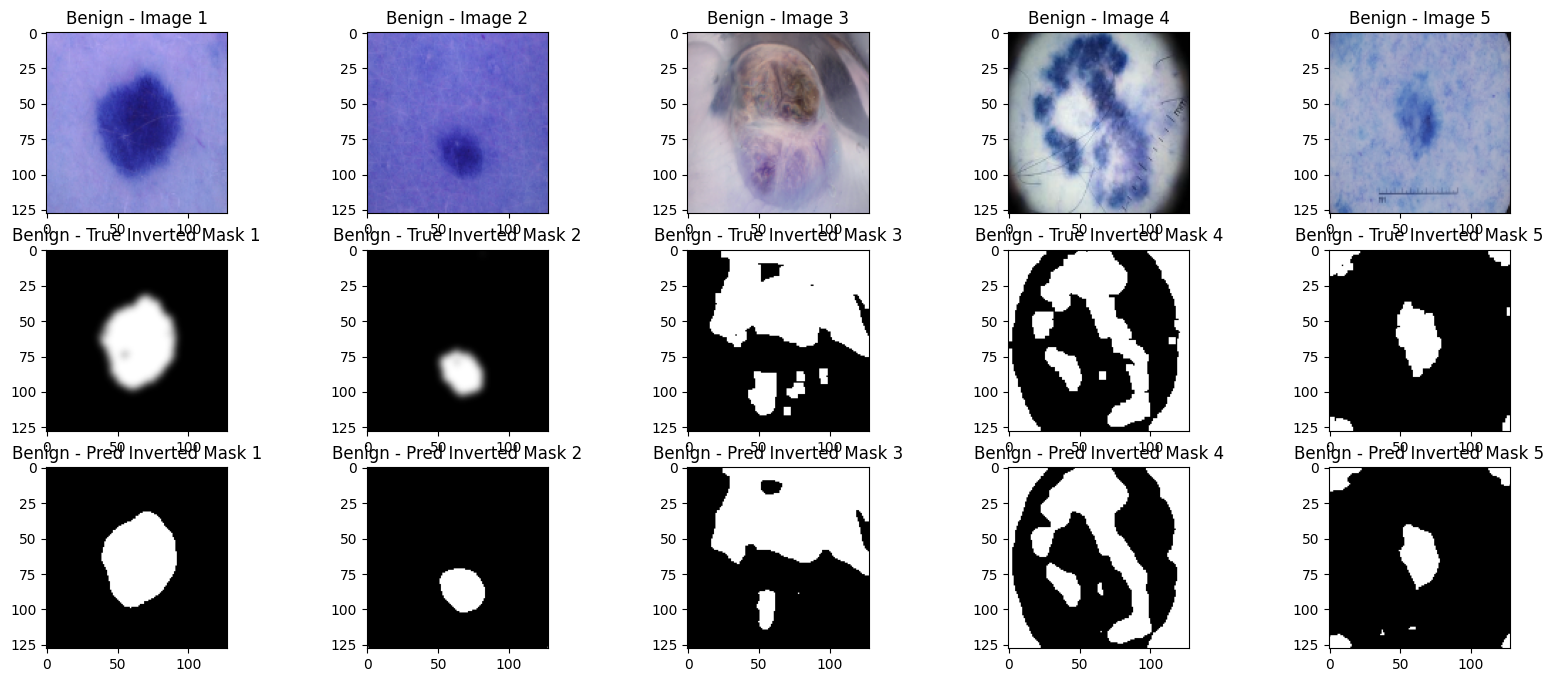

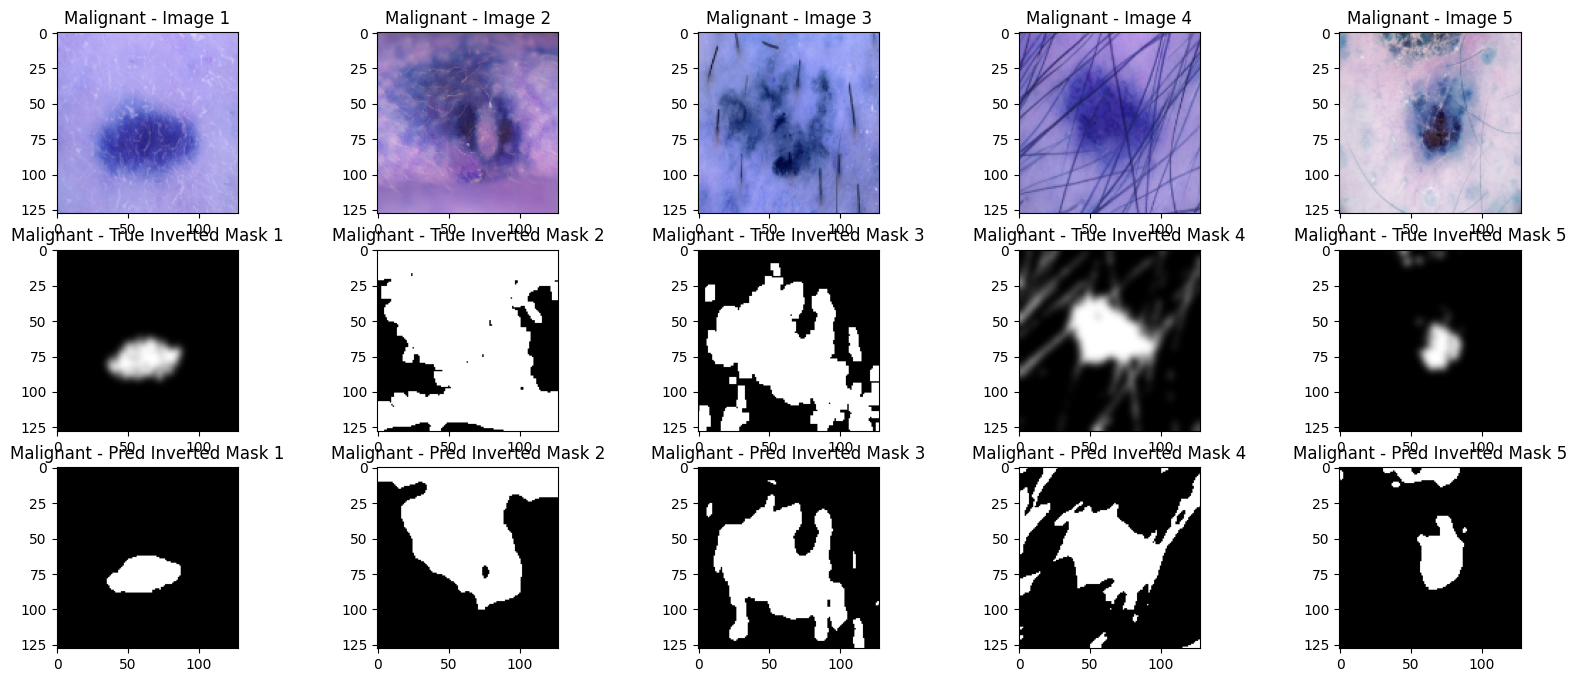

In [10]:
import matplotlib.pyplot as plt
predictions = best_model.predict(X_val)
predictions_binary = (predictions > 0.5).astype(np.uint8)
predictions_inverted = 1 - predictions_binary  # Invert the masks
predictions1 = best_model.predict(X_train)
predictions_binary = (predictions1 > 0.5).astype(np.uint8)
predictions_inverted1 = 1 - predictions_binary  # Invert the masks


# Function to display images, true inverted masks, and predicted inverted masks
def display_images(images, true_masks, pred_masks, title):
    plt.figure(figsize=(20, 8))
    for i in range(5):
        # Display original images
        plt.subplot(3, 5, i + 1)
        plt.title(f"{title} - Image {i+1}")
        plt.imshow(images[i])

        # Display true inverted masks
        plt.subplot(3, 5, i + 6)
        plt.title(f"{title} - True Inverted Mask {i+1}")
        inverted_true_mask = 1 - true_masks[i]  # Invert true mask
        plt.imshow(inverted_true_mask.squeeze(), cmap='gray')

        # Display predicted inverted masks
        plt.subplot(3, 5, i + 11)
        plt.title(f"{title} - Pred Inverted Mask {i+1}")
        plt.imshow(pred_masks[i].squeeze(), cmap='gray')

    plt.show()

# Select benign and malignant images for display (first 5 of each from the validation set)
benign_idx = np.arange(len(benign_images))[:5]
malignant_idx = np.arange(len(malignant_images))[:5]

# Display 5 benign images with true and predicted inverted masks
display_images(X_train[benign_idx], y_train[benign_idx], predictions_inverted1[benign_idx], title="Benign")

# Display 5 malignant images with true and predicted inverted masks
display_images(X_val[malignant_idx], y_val[malignant_idx], predictions_inverted[malignant_idx], title="Malignant")


In [11]:
best_model.save('/content/drive/MyDrive/best_model_segnet_Antcolony1_maskupdate_hehehe.h5')  # Save the model to Google Drive or any desired directory

print("Model saved successfully!")

Model saved successfully!
